In [3]:
import io
import fitz
import re
from PIL import Image, ImageDraw, ImageFont, ImageColor
import operator
import pandas as pd 
import numpy as np
from datetime import datetime
import math
from tqdm import tqdm

# Ploting funcs

In [4]:
def plot_genus_blocks(page_df, draw, color = '#6c899e', w = 3):
    try:
        genus_list = page_df['draw_genus'].unique()
    except:
        print("no GENUS found")
        return 

    for g in genus_list:
        temp_df = page_df[(page_df['draw_genus'] == g)]
        g_x0 = temp_df['x0'].min()
        g_y0 = temp_df['y0'].min()
        g_x1 = temp_df['x1'].max()
        g_y1 = temp_df['y1'].max()

        draw.rectangle((g_x0, g_y0, g_x1, g_y1), fill=None, outline=ImageColor.getrgb(color), width = w)
        
def plot_epithet_blocks(page_df, draw, color = '#660066', w = 3):
    try:
        epithet_list = page_df['draw_epithet'].unique()
    except:
        print("no EPITHET found")
        return 
    
    for e in epithet_list:
        temp_df = page_df[(page_df['draw_epithet'] == e)]
        e_x0 = temp_df['x0'].min()
        e_y0 = temp_df['y0'].min()
        e_x1 = temp_df['x1'].max()
        e_y1 = temp_df['y1'].max()

        draw.rectangle((e_x0, e_y0, e_x1, e_y1), fill=None, outline=ImageColor.getrgb(color), width = w)

def plot_author_blocks(page_df, draw, color = '#a3a3a3', w = 1):
    try:
        author_list = page_df['draw_author'].unique()
    except:
        print("no AUTHOR found")
        return 

    for a in author_list:
        temp_df = page_df[(page_df['draw_author'] == a)]
        e_x0 = temp_df['x0'].min()
        e_y0 = temp_df['y0'].min()
        e_x1 = temp_df['x1'].max()
        e_y1 = temp_df['y1'].max()

        draw.rectangle((e_x0, e_y0, e_x1, e_y1), fill=None, outline=ImageColor.getrgb(color), width = w)

def plot_infra_blocks(page_df, draw, color = '#ff6289', w = 1):
    try:
        infra_list = page_df['draw_infra'].unique()
    except:
        print("no INFRA Spp. found")
        return 

    for infra_spp in infra_list:
        temp_df = page_df[(page_df['draw_infra'] == infra_spp)]
        e_x0 = temp_df['x0'].min()
        e_y0 = temp_df['y0'].min()
        e_x1 = temp_df['x1'].max()
        e_y1 = temp_df['y1'].max()

        draw.rectangle((e_x0, e_y0, e_x1, e_y1), fill=None, outline=ImageColor.getrgb(color), width = w)

# Import Vol3 Index

In [5]:
#pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 3.pdf"
pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf"
index = range(616, 639)
doc = fitz.open(pdf_dir)
pages = [doc[i] for i in range(doc.pageCount)]
#index = list(range(555, 583))

pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf"
index = range(616, 639)

TARGET_DPI = 300
mat = fitz.Matrix(TARGET_DPI/ 72, TARGET_DPI/ 72)

indent_groups = []
indent_err = 15

# regex based boolean functions

In [6]:
def valid(word):
    """
    valid words are words that are:
    - at least 2 characters
        - unless it's x (symbol for hybrid)
    """
    return (not bool(re.search(r"[0-9]+[,.]?", word))) and (len(word) > 1 or word == 'x' or word == 'X' or word == '×' or word == r'\u00D7')
    
def is_genus(word):
    """
    A word in the index might be a genus if it satisfies the following properties:
    - letters: french alphabet + at most one hyphen (which is not first or last letter)
        - first letter upper case
        - all but first lowecase 
    in regex: ^[A-ZÀÂÄÈÉÊËÎÏÔŒÙÛÜŸÇ]{1}[a-zàâäèéêëîïôœùûüÿç]*[-]?[a-zàâäèéêëîïôœùûüÿç]+$ #ignoring strict beggining and end cause of noise
        * based on the current expression it'd also be at least 2 letters long
    """
    regex = r"[A-ZÀÂÄÈÉÊËÎÏÔŒÙÛÜŸÇ\u00D7]{1}[a-zàâäèéêëîïôœùûüÿç]*[-]?[a-zàâäèéêëîïôœùûüÿç]+"
    return re.search(regex, word)
    

def is_epithet(word):
    """
    A word in the index might be an epithet if it satisfies the following properties:
    - letters: french alphabet + at most one hyphen (which is not first or last letter)
        - all letters lowecase 
    in regex: ^[a-zàâäèéêëîïôœùûüÿç]+[-]?[a-zàâäèéêëîïôœùûüÿç]+$ #ignoring strict beggining and end cause of noise 
        * based on the current expression it'd also be at least 2 letters long
    """
    regex = r"[a-zàâäèéêëîïôœùûüÿç\u00D7]+[-]?[a-zàâäèéêëîïôœùûüÿç]+"
    return re.search(regex, word)
    
def is_hybrid(word):
    regex = r"^(([Xx\u00D7])|([Xx\u00D7]\.))$"
    return re.search(regex, word)

def is_infra(word):
    regex = r"^(var\.)|(subsp\.)"
    return re.search(regex, word)

# pre-processing func

In [7]:
def preprocessing(page_num, indent_err = 15):
    
    #initiate dataframe
    page_df = pd.DataFrame(pages[page_num].get_text_words(), columns =['in_x0', 'in_y0', 'in_x1', 'in_y1', 'word', 'block_no', 'line_no', 'word_no'])
    
    #add page number to dataframe
    page_df['page_num'] = np.array([page_num]*page_df.shape[0])
    #initiate all columns that will be added
    page_df['genus'] = np.array([np.NaN]*page_df.shape[0])
    page_df['draw_genus'] = np.array([np.NaN]*page_df.shape[0])
    page_df['epithet'] = np.array([np.NaN]*page_df.shape[0])
    page_df['draw_epithet'] = np.array([np.NaN]*page_df.shape[0])
    page_df['author'] = np.array([np.NaN]*page_df.shape[0])
    page_df['draw_author'] = np.array([np.NaN]*page_df.shape[0])
    page_df['infra'] = np.array([np.NaN]*page_df.shape[0])
    page_df['draw_infra'] = np.array([np.NaN]*page_df.shape[0])
    page_df['taxon rank'] = np.array([np.NaN]*page_df.shape[0])
    page_df['error_check'] = np.array([np.NaN]*page_df.shape[0])
    #updating coordinates to represent target DPI
    page_df['x0'], page_df['y0'], page_df['x1'], page_df['y1'] = page_df['in_x0']*TARGET_DPI/ 72, page_df['in_y0']*TARGET_DPI/ 72, page_df['in_x1']*TARGET_DPI/ 72, page_df['in_y1']*TARGET_DPI/ 72
    #get x corner coordinates 
    x_min = page_df['x0'].min()
    x_max = page_df['x1'].max()

    #invalid words dataframe -- for error checking
    pruned_words_df = page_df[~page_df["word"].apply(valid)].reset_index()
    #prune out invalid words (based on function valid)
    page_df = page_df[page_df["word"].apply(valid)].reset_index()
    
    indent_groups = []
    blocks = page_df['block_no'].unique()
    for b in blocks:
        lines = page_df[page_df['block_no'] == b]['line_no'].unique()
        for l in lines:
            #reset word_no values (useful for cases where word that was originally at 0th index was pruned out)
            cond = (page_df['line_no'] == l) & (page_df['block_no'] == b)
            num_words = len(page_df[cond]['word_no'])
            page_df.loc[cond, 'word_no'] = np.arange(num_words).astype(int) #this is slowww
            #set column number (0 or 1)
            x_0 = page_df[cond]['x0'].min()
            #THIS DOESN'T WORK AAAA -- issue was with line no thing
            if not np.isnan(x_0):
                page_df.loc[cond, 'col_no'] = np.array([int(x_0 > ((x_min + x_max) / 2))]*num_words).astype(int)

                #initiate indent groups -- only first word should get an indent_group value 
                new_group = True
                for g_i in range(len(indent_groups)):
                    g = indent_groups[g_i]
                    g_arr = np.array(g)
                    if x_0 <= np.mean(g_arr) + indent_err and x_0 >= np.mean(g_arr) - indent_err:
                        g.append(x_0)
                        new_group = False
                        page_df.loc[cond, 'indent_group'] = np.array([g_i]*num_words).astype(int)
                if new_group:
                    indent_groups.append([x_0])
                    g_i = len(indent_groups) - 1
                    page_df.loc[cond, 'indent_group'] = np.array([g_i]*num_words).astype(int)


    #return updated page_df, pruned_words_df, indent groups
    return page_df.reset_index(), pruned_words_df, indent_groups

#https://stackoverflow.com/questions/53468558/adding-image-to-pandas-dataframe

In [8]:
genus = np.NaN
df_dict = {}
pruned_dict = {}

for page_num in tqdm(index):
    page_df, pruned_df, indent_group = preprocessing(page_num)
    df_dict[page_num] = page_df
    pruned_dict[page_num] = pruned_df

100%|██████████| 23/23 [00:08<00:00,  2.77it/s]


# Finding indentations associated with genus, epithet, infra

In [9]:
types = ['genus', 'epithet', 'infra', 'author', 'misc.']
def n_leftmost_indent(df, n):
    """return a tuple with at most 3 elements each element itself is a tuple containing indent group, mean, group len"""
    indent_groups = [(g, df[(df['indent_group'] == g) & (df['word_no'] == 0)]['x0'].mean(), len(df[(df['indent_group'] == g) & (df['word_no'] == 0)]['x0'])) for g in df['indent_group'].unique()]
    indent_groups.sort(key = lambda x : x[1])
    return indent_groups[:n]

In [10]:
def get_genusEpithetInfra_indent(col_df):
    leftmost_3_indents = n_leftmost_indent(col_df, 3) 
    min_gap = 0
    max_gap = 75

    # possibly not specific enough
    # first identifying indent based don distance from one another only
    if len(leftmost_3_indents) == 3:
        if leftmost_3_indents[0][1] < max_gap:
            leftmost_3_indents = leftmost_3_indents[1:]
        elif ((leftmost_3_indents[1][1] - leftmost_3_indents[0][1]) > max_gap or \
            (leftmost_3_indents[1][1] - leftmost_3_indents[0][1]) < min_gap): #comparing first two (if satisfied last two will be checked in next if block)
            leftmost_3_indents = [max(leftmost_3_indents[1:], key = lambda x : x[2])] + [leftmost_3_indents[2]]
        elif (leftmost_3_indents[2][1] - leftmost_3_indents[1][1]) > max_gap or \
            (leftmost_3_indents[2][1] - leftmost_3_indents[1][1]) < min_gap: #comparing last two
            leftmost_3_indents = [leftmost_3_indents[0]] + [max(leftmost_3_indents[1:], key = lambda x : x[2])]

    if len(leftmost_3_indents) == 2:
        if leftmost_3_indents[0][1] < max_gap:
            leftmost_3_indents = leftmost_3_indents[1]
        elif (leftmost_3_indents[1][1] - leftmost_3_indents[0][1]) > max_gap or (leftmost_3_indents[1][1] - leftmost_3_indents[0][1]) < min_gap:
            leftmost_3_indents = [max(leftmost_3_indents, key = lambda x : x[2])]

    has_genus, has_epithet, has_infra = False, False, False
    genus_indent, epithet_indent, infra_indent = -1, -1, -1
    if len(leftmost_3_indents) == 3:
        has_genus, has_epithet, has_infra = True, True, True
        genus_indent, epithet_indent, infra_indent = [el[0] for el in leftmost_3_indents]
    elif len(leftmost_3_indents) == 2:
        if col_df[col_df['indent_group'] == leftmost_3_indents[1][0]]['word'].apply(is_infra).any():
            has_genus, has_epithet, has_infra = False, True, True
            epithet_indent, infra_indent = [el[0] for el in leftmost_3_indents]
        else:
            has_genus, has_epithet, has_infra = True, True, False
            genus_indent, epithet_indent = [el[0] for el in leftmost_3_indents]
    elif len(leftmost_3_indents) == 2: 
        has_genus, has_epithet, has_infra = False, True, False
        epithet_indent = leftmost_3_indents[0][0]

    return genus_indent, epithet_indent, infra_indent, leftmost_3_indents

# Processing column dataframes


In [45]:
def process_col(col_df, genus, epithet, draw_genus, draw_epithet, draw_infra = np.NaN):
    genus_indent, epithet_indent, infra_indent, indent_3_left = get_genusEpithetInfra_indent(col_df)
    print(genus_indent, epithet_indent, infra_indent, indent_3_left)
    
    blocks = col_df['block_no'].unique()
    start_word_cond = -1 
    author = ''
    #draw_infra = np.NaN
    
    for b in blocks:
        lines = col_df[col_df['block_no'] == b]['line_no'].unique()
        for l in lines:
            cond = (col_df['line_no'] == l) & (col_df['block_no'] == b)
            words = col_df[cond]['word_no'].unique()
            process_hybrid = False
            process_infra = False
            
            col_df = col_df.copy()
            for w in words:
                word_cond = (col_df['line_no'] == l) & (col_df['block_no'] == b) & (col_df['word_no'] == w) 
                word = col_df[word_cond]['word'].item()
                #print(word)
            
                if w == 0:
                    infra = ''
                    if author != '':
                        col_df.loc[start_word_cond, 'author'] = author
                        author = ''
                    
                    start_word_cond = word_cond
                    start_l = l 
                    start_b = b 

                    indent_group = col_df[word_cond]['indent_group'].item()
                    
                    if is_hybrid(word):
                        process_hybrid = True
                        misc = word
                        author = ''
                        #col_df.loc[start_word_cond, 'misc.'] = misc
                    #now only gotta say INDENT AND satisfies these paterns
                    #print(indent_group, genus_indent)
                    else: 
                        if indent_group == genus_indent:
                            if not ''.join(e for e in word if e.isalpha()).isupper():
                                genus = word
                                misc = ''
                                author = ''
                                infra = ''
                                epithet = ''
                                draw_genus = genus
                                col_df.loc[start_word_cond, 'genus'] = genus
                                col_df.loc[start_word_cond, 'taxon rank'] = 'genus'
                                if not is_genus(word):
                                    col_df.loc[start_word_cond, 'error_check'] = True
                                col_df.loc[word_cond, 'draw_genus'] = draw_genus
                                
                            else: 
                                genus = ''
                                misc = ''
                                author = ''
                                infra = ''
                                epithet = ''
                                draw_genus = np.NaN
                        elif indent_group == epithet_indent and not ''.join(e for e in word if e.isalpha()).isupper():
                            epithet = word
                            misc = ''
                            infra = ''
                            author = ''
                            col_df.loc[start_word_cond, 'genus'] = genus
                            col_df.loc[start_word_cond, 'epithet'] = epithet
                            col_df.loc[start_word_cond, 'taxon rank'] = 'species'
                            if not is_epithet(word):
                                col_df.loc[start_word_cond, 'error_check'] = True
                            draw_epithet = str(genus) + '_' + str(epithet) +'_' + str(start_b) + '_' + str(start_l)
                            col_df.loc[word_cond, 'draw_genus'] = draw_genus
                            col_df.loc[word_cond, 'draw_epithet'] = draw_epithet
                        

                        elif indent_group == infra_indent:
                            process_infra = True
                            misc = word
                            author = ''
                            #col_df.loc[start_word_cond, 'misc.'] = misc
                            if not (is_infra(word) or is_hybrid(word)):
                                col_df.loc[start_word_cond, 'error_check'] = True
                    
                elif process_infra:
                    start_word_cond = word_cond
                    start_l = l 
                    start_b = b 
                    infra = word 
                    col_df.loc[start_word_cond, 'genus'] = genus
                    col_df.loc[start_word_cond, 'epithet'] = epithet
                    col_df.loc[start_word_cond, 'infra'] = infra
                    #col_df.loc[start_word_cond, 'misc.'] = misc
                    col_df.loc[start_word_cond, 'taxon rank'] = misc
                    draw_infra = str(infra) + '_'+str(start_b)+'_'+str(start_l)
                    process_infra = False
                    col_df.loc[word_cond, 'draw_genus'] = draw_genus
                    col_df.loc[word_cond, 'draw_epithet'] = draw_epithet
                    col_df.loc[word_cond, 'draw_infra'] = draw_infra
                    
                elif process_hybrid:
                    start_word_cond = word_cond
                    start_l = l 
                    start_b = b 
                    if indent_group == genus_indent:
                        genus = word
                        epithet = ''
                        infra = ''
                        author = ''
                        draw_genus = genus
                        col_df.loc[start_word_cond, 'genus'] = genus
                        col_df.loc[start_word_cond, 'taxon rank'] = 'genus - hybrid'
                        if not is_genus(word):
                            col_df.loc[start_word_cond, 'error_check'] = True
                        col_df.loc[word_cond, 'draw_genus'] = draw_genus
                            
                    elif indent_group == epithet_indent:
                        epithet = word
                        author = ''
                        infra = ''
                        col_df.loc[start_word_cond, 'genus'] = genus
                        col_df.loc[start_word_cond, 'epithet'] = epithet
                        col_df.loc[start_word_cond, 'taxon rank'] = 'species - hybrid'
                        draw_epithet = str(genus) + '_' + str(epithet) +'_' + str(start_b) + '_' + str(start_l)
                        if not is_epithet(word):
                            col_df.loc[start_word_cond, 'error_check'] = True
                        col_df.loc[word_cond, 'draw_genus'] = draw_genus
                        col_df.loc[word_cond, 'draw_epithet'] = draw_epithet
                    elif indent_group == infra_indent:
                        infra = word
                        col_df.loc[start_word_cond, 'genus'] = genus
                        col_df.loc[start_word_cond, 'epithet'] = epithet
                        col_df.loc[start_word_cond, 'infra'] = infra
                        col_df.loc[start_word_cond, 'taxon rank'] = 'hybrid'
                        col_df.loc[word_cond, 'draw_genus'] = draw_genus
                        col_df.loc[word_cond, 'draw_epithet'] = draw_epithet
                        col_df.loc[word_cond, 'draw_infra'] = draw_infra
                    #col_df.loc[start_word_cond, 'misc.'] = 'x'
                    process_hybrid = False
                else:
                    if w == 1 and epithet == '': 
                        epithet = word
                        misc = ''
                        infra = ''
                        author = ''
                        col_df.loc[start_word_cond, 'genus'] = genus
                        col_df.loc[start_word_cond, 'epithet'] = epithet
                        col_df.loc[start_word_cond, 'taxon rank'] = 'species'
                        if not is_epithet(word):
                            col_df.loc[start_word_cond, 'error_check'] = True
                        draw_epithet = str(genus) + '_' + str(epithet) +'_' + str(start_b) + '_' + str(start_l)
                        col_df.loc[word_cond, 'draw_genus'] = draw_genus
                        col_df.loc[word_cond, 'draw_epithet'] = draw_epithet
                    author = author + word + ' '
                    col_df.loc[word_cond, 'draw_author'] = 'author_'+str(start_b)+'_'+str(start_l)
                    #col_df.loc[word_cond, 'draw_genus'] = draw_genus
                    #if epithet:
                    #    col_df.loc[word_cond, 'draw_epithet'] = draw_epithet
                    #if infra: 
                    #    col_df.loc[word_cond, 'draw_infra'] = draw_infra

    #Last author
    if author != '':
        col_df.loc[start_word_cond, 'author'] = author
    
    return col_df, genus, epithet, draw_genus, draw_epithet

# the Results

In [46]:
genus = np.NaN
epithet = np.NaN
draw_genus = np.NaN
draw_epithet = np.NaN
result_ims = []
df_list = []

for page_num in tqdm(index):
    #page_num = index[-1]
    #process the pre-processed dfs
    page_df = df_dict[page_num]
    
    #for drawing
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)

    #processing each column
    for c in page_df['col_no'].unique():
        col_df = page_df[page_df['col_no'] == c]
        col_df, genus, epithet, draw_genus, draw_epithet = process_col(col_df, genus, epithet, draw_genus, draw_epithet)
        df_list.append(col_df)

        #drawing boxes in each column
        plot_genus_blocks(col_df, draw)
        plot_epithet_blocks(col_df, draw)
        plot_author_blocks(col_df, draw)
        plot_infra_blocks(col_df, draw)

    result_ims.append(image)
    #break 
TIME_STR = datetime.now().strftime("%Y_%m_%d-%I_%M_%p")
result_ims[0].save('../output/index/PDF/vol1_index_reverted_ROI'+TIME_STR+'.pdf',save_all=True, append_images=result_ims[1:])

pre_processed_df = pd.concat([df_dict[k] for k in df_dict], axis = 0)
df = pd.concat(df_list, axis = 0)
df.to_html('../output/index/html/vol1_index_reverted'+TIME_STR+'.html')
pre_processed_df.to_html('../output/index/html/vol1_preprocessed_index'+TIME_STR+'.html')
df.to_csv('../output/index/CSV/vol1_index_reverted'+TIME_STR+'.csv', index = False)

pruned = df[(~df['genus'].isnull())]
pruned = pruned[["page_num", "genus", "epithet", "infra" ,"author", "taxon rank"]]
pruned.to_csv('../output/index/CSV/vol1_index_reverted_pruned'+TIME_STR+'.csv', index = False)
pruned.to_html('../output/index/html/vol1_index_reverted_pruned'+TIME_STR+'.html')

  0%|          | 0/23 [00:00<?, ?it/s]

2.0 1.0 -1 [(2.0, 116.37499829133353, 8), (1.0, 172.15384744171408, 39)]
3.0 4.0 -1 [(3.0, 972.6666627106845, 9), (4.0, 1030.1499970753987, 40)]


  4%|▍         | 1/23 [00:01<00:27,  1.24s/it]

2.0 1.0 -1 [(2.0, 123.00000190734863, 2), (1.0, 184.4999977520534, 56)]
7.0 6.0 -1 [(7.0, 985.428573971703, 7), (6.0, 1039.823529611226, 51)]


  9%|▊         | 2/23 [00:02<00:26,  1.27s/it]

1.0 2.0 -1 [(1.0, 81.60000085830688, 10), (2.0, 137.95833239952722, 48)]
5.0 4.0 -1 [(5.0, 938.3333365122479, 12), (4.0, 994.3043418552568, 46)]


 13%|█▎        | 3/23 [00:03<00:23,  1.19s/it]

2.0 1.0 -1 [(2.0, 234.29999987284344, 10), (1.0, 289.5625001854367, 48)]
3.0 4.0 -1 [(3.0, 1090.0999704996743, 10), (4.0, 1146.2083260218303, 48)]


 17%|█▋        | 4/23 [00:04<00:22,  1.17s/it]

2.0 1.0 -1 [(2.0, 88.75000013245477, 12), (1.0, 145.8409092643044, 44)]
5.0 4.0 -1 [(5.0, 943.7692397680039, 13), (4.0, 998.5777720698605, 45)]


 22%|██▏       | 5/23 [00:05<00:21,  1.17s/it]

2.0 1.0 -1 [(2.0, 185.77777897870098, 9), (1.0, 244.34042518020522, 47)]
4.0 5.0 3.0 [(4.0, 1040.6666808658176, 12), (5.0, 1091.8571472167966, 7), (3.0, 1101.6410240760217, 39)]


 26%|██▌       | 6/23 [00:06<00:19,  1.13s/it]

2.0 1.0 -1 [(2.0, 136.70000076293942, 10), (1.0, 192.31250087420145, 48)]
4.0 3.0 -1 [(4.0, 991.2857101077124, 14), (3.0, 1046.6136397737446, 44)]


 30%|███       | 7/23 [00:08<00:18,  1.13s/it]

2.0 1.0 -1 [(2.0, 217.60000228881836, 15), (1.0, 274.4051164434861, 43)]
3.0 4.0 -1 [(3.0, 1076.5454378995028, 11), (4.0, 1129.4666685881436, 45)]


 35%|███▍      | 8/23 [00:09<00:17,  1.14s/it]

2.0 1.0 -1 [(2.0, 102.99999872843425, 15), (1.0, 158.6585358875554, 41)]
4.0 3.0 -1 [(4.0, 961.5555515995732, 18), (3.0, 1016.8947336966529, 38)]


 39%|███▉      | 9/23 [00:10<00:15,  1.14s/it]

2.0 1.0 -1 [(2.0, 130.12500007947287, 8), (1.0, 183.08333158493042, 48)]
3.0 4.0 -1 [(3.0, 988.1249984105427, 16), (4.0, 1041.9385985722615, 42)]


 43%|████▎     | 10/23 [00:11<00:14,  1.11s/it]

2.0 1.0 -1 [(2.0, 97.66666889190674, 15), (1.0, 153.14634214571822, 41)]
3.0 4.0 -1 [(3.0, 956.1999893188477, 15), (4.0, 1012.2517696646755, 43)]


 48%|████▊     | 11/23 [00:12<00:13,  1.11s/it]

2.0 1.0 -1 [(2.0, 144.00000042385525, 6), (1.0, 195.4062379201253, 50)]
5.0 4.0 -1 [(5.0, 1000.0769150562775, 13), (4.0, 1057.0412667592368, 40)]


 52%|█████▏    | 12/23 [00:13<00:11,  1.09s/it]

2.0 1.0 -1 [(2.0, 105.38095216902474, 21), (1.0, 161.05882373510622, 34)]


 57%|█████▋    | 13/23 [00:14<00:10,  1.07s/it]

4.0 5.0 6.0 [(4.0, 967.5333404541016, 15), (5.0, 1022.4102558233793, 39), (6.0, 1080.0000508626301, 1)]
2.0 1.0 -1 [(2.0, 118.6363624803948, 11), (1.0, 175.39534827535468, 43)]
8.0 7.0 -1 [(8.0, 980.9285708836145, 14), (7.0, 1036.6097582064992, 41)]


 61%|██████    | 14/23 [00:15<00:10,  1.12s/it]

2.0 1.0 -1 [(2.0, 79.49999968210855, 4), (1.0, 134.2222238764351, 54)]
5.0 4.0 -1 [(5.0, 941.0714285714286, 14), (4.0, 996.7857103499155, 42)]


 65%|██████▌   | 15/23 [00:16<00:08,  1.11s/it]

1.0 2.0 -1 [(1.0, 139.76922768812912, 13), (2.0, 195.79545548467922, 44)]
6.0 5.0 -1 [(6.0, 1000.9999956403461, 14), (5.0, 1056.6136259021182, 44)]


 70%|██████▉   | 16/23 [00:18<00:07,  1.10s/it]

2.0 1.0 -1 [(2.0, 80.88889122009277, 9), (1.0, 136.11077710884769, 49)]
5.0 4.0 -1 [(5.0, 939.8750066757202, 16), (4.0, 995.4761823018392, 42)]


 74%|███████▍  | 17/23 [00:19<00:06,  1.10s/it]

2.0 1.0 3.0 [(2.0, 147.55555435463233, 9), (1.0, 204.48837132416952, 43), (3.0, 274.00000890096027, 1)]
4.0 5.0 -1 [(4.0, 1011.3333384195963, 6), (5.0, 1067.4799982706706, 50)]


 78%|███████▊  | 18/23 [00:20<00:05,  1.09s/it]

1.0 2.0 -1 [(1.0, 81.14285809653146, 7), (2.0, 132.1176474390466, 51)]
4.0 3.0 -1 [(4.0, 940.0833394792345, 12), (3.0, 993.0434807487156, 46)]


 83%|████████▎ | 19/23 [00:21<00:04,  1.07s/it]

2.0 1.0 -1 [(2.0, 131.00000023841858, 12), (1.0, 187.06521849701372, 46)]
-1 -1 -1 [(3.0, 1047.7413736540695, 58)]


 87%|████████▋ | 20/23 [00:22<00:03,  1.05s/it]

2.0 1.0 3.0 [(2.0, 80.437500278155, 16), (1.0, 136.95238090696787, 42), (3.0, 192.00000762939453, 1)]
5.0 4.0 -1 [(5.0, 940.5833350287545, 12), (4.0, 997.4090922962537, 44)]


 91%|█████████▏| 21/23 [00:23<00:02,  1.07s/it]

1.0 2.0 -1 [(1.0, 169.77777657685454, 9), (2.0, 222.23404248555497, 47)]
5.0 6.0 4.0 [(5.0, 1027.3571423121862, 14), (6.0, 1057.9999923706055, 1), (4.0, 1083.5791093331798, 36)]


100%|██████████| 23/23 [00:24<00:00,  1.08s/it]

-1 -1 -1 [(2.0, 115.91666738192242, 12)]
3.0 4.0 -1 [(3.0, 918.374999364217, 8), (4.0, 973.9999771118164, 2)]


In [42]:
df_list[-1]
#df_dict[index[-1]]
#result_ims[-1]

,level_0,index,in_x0,in_y0,in_x1,in_y1,word,block_no,line_no,word_no,...,infra,draw_infra,taxon rank,error_check,x0,y0,x1,y1,col_no,indent_group
37,37,59,221.279999,60.010010,273.777039,69.010010,Weingartneria,7,0,0,...,NaN,NaN,genus,NaN,921.999995,250.041707,1140.737661,287.541707,1.0,3.0
38,38,60,221.039993,69.130005,247.279922,78.130005,Wolffia,7,1,0,...,NaN,NaN,species,NaN,920.999972,288.041687,1030.333010,325.541687,1.0,3.0
39,39,61,249.412064,69.130005,275.652039,78.130005,arrhiza,7,1,1,...,NaN,NaN,NaN,NaN,1039.216932,288.041687,1148.550161,325.541687,1.0,3.0
40,40,62,278.440338,69.130005,292.452698,78.130005,(L.),7,1,2,...,NaN,NaN,NaN,NaN,1160.168076,288.041687,1218.552907,325.541687,1.0,3.0
41,41,63,294.912750,69.130005,323.674316,78.130005,Wimm.,7,1,3,...,NaN,NaN,NaN,NaN,1228.803126,288.041687,1348.642985,325.541687,1.0,3.0
42,42,65,220.320007,97.659973,268.504486,107.659973,Zannichellia,9,0,0,...,NaN,NaN,genus,NaN,918.000031,406.916555,1118.768692,448.583221,1.0,3.0
43,43,66,233.759995,108.219971,266.100891,118.219971,palustris,10,0,0,...,NaN,NaN,species,NaN,973.999977,450.916545,1108.753713,492.583211,1.0,4.0
44,44,67,269.266327,108.219971,277.663513,118.219971,L.,10,0,1,...,NaN,NaN,NaN,NaN,1121.943029,450.916545,1156.931305,492.583211,1.0,4.0
45,45,68,219.839996,117.609985,233.205002,126.609985,Zea,11,0,0,...,NaN,NaN,species,NaN,915.999985,490.041606,971.687508,527.541606,1.0,3.0
46,46,69,235.708710,117.609985,254.020187,126.609985,mays,11,0,1,...,NaN,NaN,NaN,NaN,982.119624,490.041606,1058.417447,527.541606,1.0,3.0


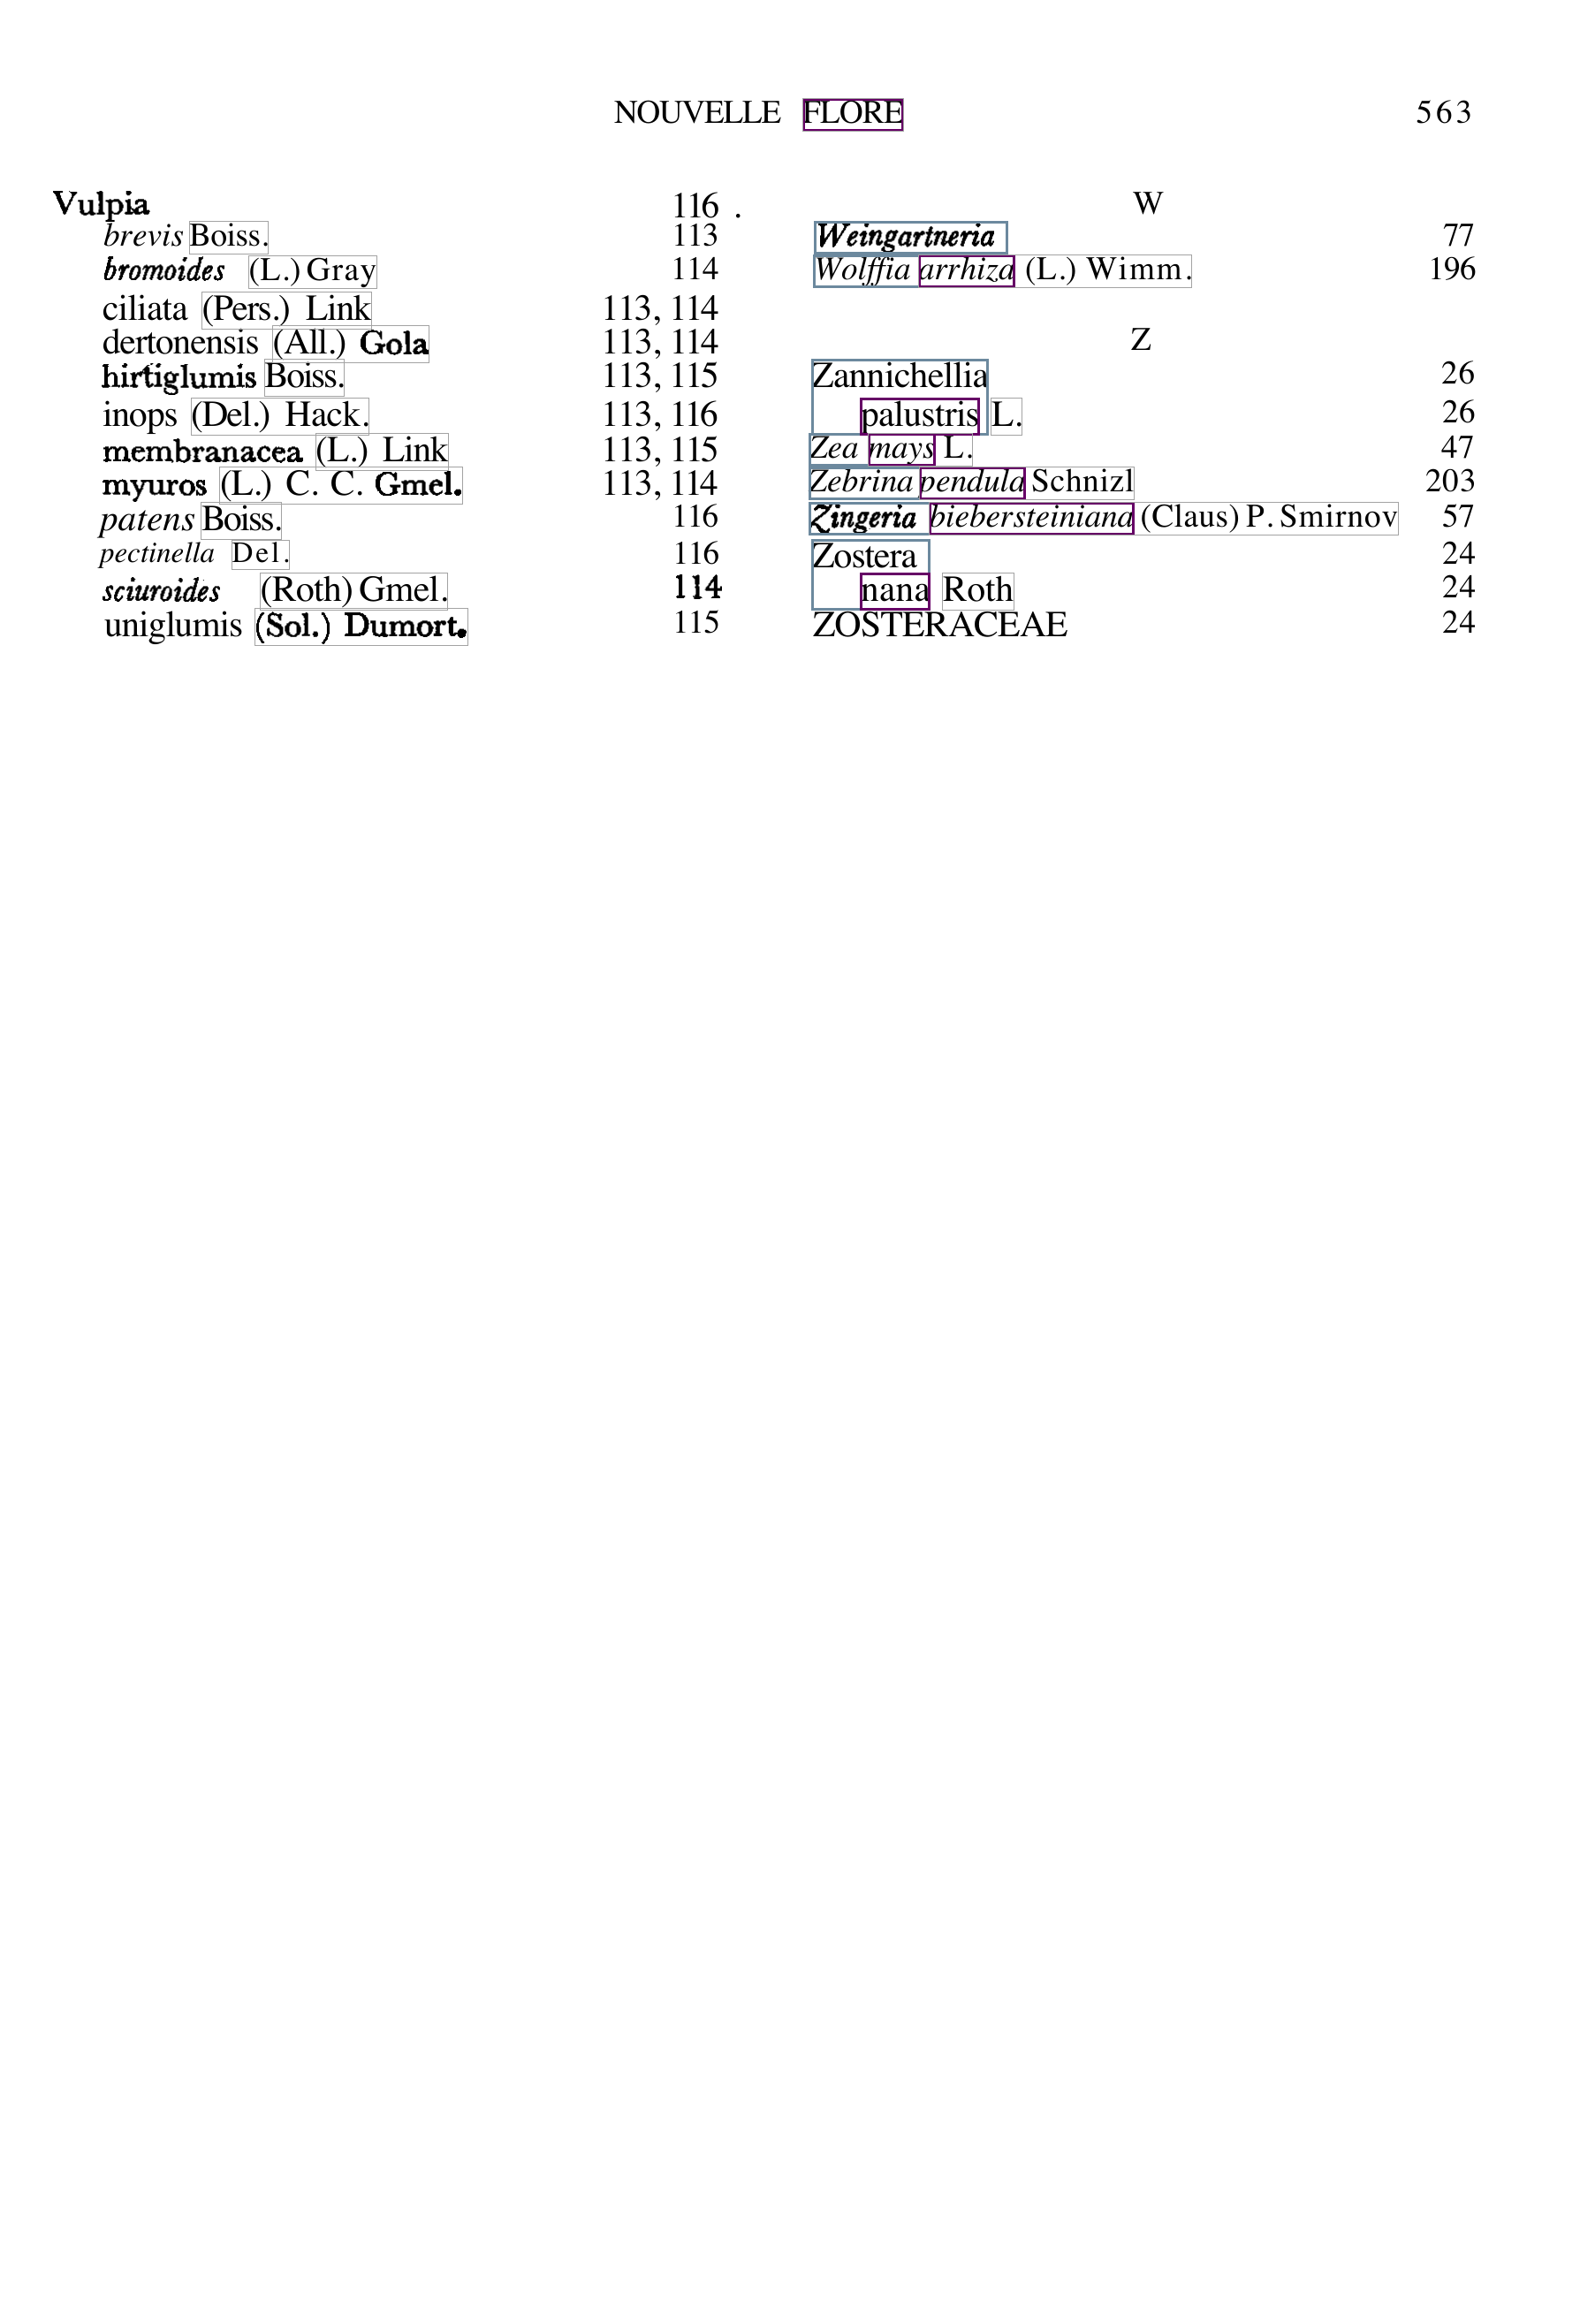

In [44]:
result_ims[-1]